In [1]:
# Run to import necessary libraries
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
import matplotlib.pyplot as plt
import numpy as np

In [2]:
batch_size = 32
num_epochs = 5
data_dir = '~/data'

torch.set_float32_matmul_precision('high')

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Mean and std of MNIST
])
train_data = datasets.MNIST(root = data_dir, train = True, transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = data_dir, train = False , transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = False)

test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)

In [3]:
from time import perf_counter

def train(model, loss_fn, optimizer, train_loader, test_loader, batch_size, num_epochs, device, conv):
    total_time = 0;
    losses = [[], [], []]
    if device is not None:
        model.to(device)
    else:
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(device)
        model.to(device)
    for epoch in range(num_epochs):
        start_time = perf_counter()
        tr_loss_average = 0
        for i, data in enumerate(train_loader, 0):
            images, labels = data[0].to(device), data[1].to(device)
            if conv:
                images = images.view(-1, 1, 28, 28)
            else:
                images = images.view(-1, input_size)
            optimizer.zero_grad()
            outputs = model(images)
            tr_loss = loss_fn(outputs, labels)
            tr_loss_average += tr_loss.item()
            tr_loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                v_loss_average = 0
                count_va = 0
                for _, data in enumerate(test_loader, 0):
                    images, labels = data[0].to(device), data[1].to(device)
                    if conv:
                        images = images.view(-1, 1, 28, 28)
                    else:
                        images = images.view(-1, input_size)
                    outputs = model(images)
                    v_loss_average += loss_fn(outputs, labels).item()
                    count_va += 1

                tr_loss_average /= 100
                v_loss_average /= count_va
                losses[0].append((epoch) * 1875 + (i+1))
                losses[1].append(tr_loss_average)
                losses[2].append(v_loss_average)
                print('Epoch [%d/%d], Step [%d/%d], Train Loss: %.4f, Val Loss: %.4f'
                            %(epoch+1, num_epochs, i+1,
                            len(train_loader), tr_loss_average, v_loss_average))
                tr_loss_average = 0

        stop_time = perf_counter()
        #val_acc = test_accuracy(model, test_loader, 784, device, conv)
        #train_acc = test_accuracy(model, train_loader, 784, device, conv)
        time = stop_time - start_time
        #print('Epoch [%d/%d] End. Duration %.4f seconds. Train Acc: %.4f, Val Acc: %.4f'
        print('Epoch [%d/%d] End. Duration %.4f seconds.' %(epoch+1, num_epochs, time))
                            #%(epoch+1, num_epochs, time, train_acc, val_acc))
        total_time += time

    return (losses, total_time)

In [4]:
# Define 5-Layer Network w/ batch normalization
class Net5(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net5,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2, stride = 1)
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding = 2)
        self.fc1 = nn.Linear(14*14*64, 1024)
        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self,x):
        out = self.conv1(x)
        out = self.batch_norm1(out)
        out = self.pooling(out)
        out = self.conv2(out)
        out = self.batch_norm2(out)
        out = self.relu(out)
        out = torch.flatten(out, start_dim=1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# ...

# Net5
input_size = 28*28
num_classes = 10
lr = 0.0003
num_epochs = 10
batch_size = 64
net = Net5(input_size, num_classes)
for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
losses_net5, total_time = train(net, loss_function, optimizer, train_loader, test_loader, batch_size, num_epochs, device, True)

print("Total Training Time in Seconds: ", total_time, " seconds")

Epoch [1/10], Step [100/1875], Train Loss: 1.1729, Val Loss: 0.3698
Epoch [1/10], Step [200/1875], Train Loss: 0.2776, Val Loss: 0.2656
Epoch [1/10], Step [300/1875], Train Loss: 0.2475, Val Loss: 0.1898
Epoch [1/10], Step [400/1875], Train Loss: 0.1912, Val Loss: 0.1887
Epoch [1/10], Step [500/1875], Train Loss: 0.1569, Val Loss: 0.1297
Epoch [1/10], Step [600/1875], Train Loss: 0.1188, Val Loss: 0.0847
Epoch [1/10], Step [700/1875], Train Loss: 0.1102, Val Loss: 0.1392
Epoch [1/10], Step [800/1875], Train Loss: 0.1056, Val Loss: 0.0870
Epoch [1/10], Step [900/1875], Train Loss: 0.1049, Val Loss: 0.0824
Epoch [1/10], Step [1000/1875], Train Loss: 0.1040, Val Loss: 0.0727
Epoch [1/10], Step [1100/1875], Train Loss: 0.0859, Val Loss: 0.0917
Epoch [1/10], Step [1200/1875], Train Loss: 0.0982, Val Loss: 0.0732
Epoch [1/10], Step [1300/1875], Train Loss: 0.0857, Val Loss: 0.0804
Epoch [1/10], Step [1400/1875], Train Loss: 0.0797, Val Loss: 0.0678
Epoch [1/10], Step [1500/1875], Train Loss:

In [5]:
def evaluate(model, data_loader, loss_fn, device, conv, input_size=784):
    """
    Evaluates the model on the given data_loader.
    Returns average loss and accuracy.
    """
    model.eval()  # set model to eval mode
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(device), data[1].to(device)
            if conv:
                images = images.view(-1, 1, 28, 28)
            else:
                images = images.view(-1, input_size)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total

    return avg_loss, accuracy
loss, accuracy = evaluate(net, test_loader, loss_function, device, True)

print("Total Loss: ", loss, "and Total Accuracy: ", accuracy * 100,"%")

Total Loss:  0.03797802091466926 and Total Accuracy:  99.1 %


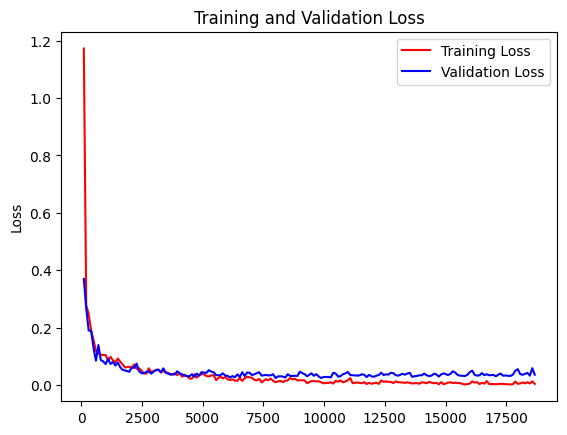

In [6]:
def plot_learning_curve(steps, training_loss, validation_loss):
    plt.plot(steps, training_loss, 'r-', label='Training Loss')
    plt.plot(steps, validation_loss, 'b-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
plot_learning_curve(losses_net5[0], losses_net5[1], losses_net5[2])